# Deep RL Usage Tutorial

This notebook is meant to demonstrate how to use the included DeepRL algorithms (PPO and SAC) to train agents in the GridEnv environment.

## Training an agent

In [1]:
from neuronav.deep_agents.ppo.agent import PPOAgent
from neuronav.deep_agents.sac.agent import SACAgent
from neuronav.envs.grid_env import GridEnv, GridObservation, GridSize, GridTemplate
import torch
import matplotlib.pyplot as plt
from neuronav.utils import run_episode
import math
import numpy as np

%config InlineBackend.figure_format = 'retina'

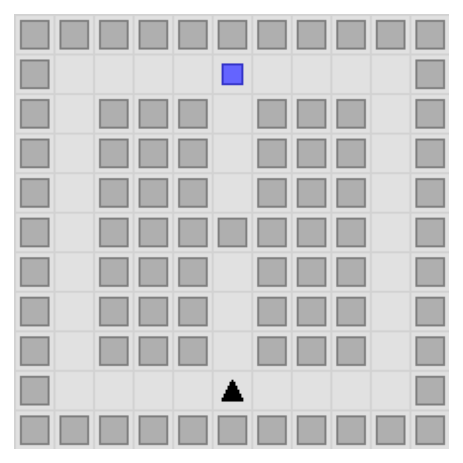

In [2]:
env = GridEnv(
    obs_type=GridObservation.geometric,
    template=GridTemplate.detour_block,
    size=GridSize.small,
    torch_obs=True,
)
obs = env.reset()
env.render()

In [3]:
visual_types = [
    GridObservation.window,
    GridObservation.visual,
    GridObservation.rendered_3d,
]


def get_model_params(env):
    if env.obs_mode in visual_types:
        enc_type = "conv64"
    else:
        enc_type = "linear"
    model_params = {
        "enc_type": enc_type,
        "h_size": 128,
        "lr": 3e-4,
        "obs_size": math.prod(env.obs_space.shape),
        "act_size": env.action_space.n,
        "depth": 3,
    }
    return model_params


agent_params_sac = {
    "batch_size": 32,
    "gamma": 0.99,
    "tau": 0.005,
    "target_update_interval": 4,
    "replay_buffer_size": 100000,
    "update_interval": 4,
    "warmup_steps": 1000,
    "alpha": 0.02,
}

agent_params_ppo = {
    "gamma": 0.99,
    "lambda": 0.95,
    "buffer_size": 256,
    "ent_coef": 0.05,
    "num_passes": 2,
    "clip_param": 0.2,
    "batch_size": 32,
}

### Train the agent in the gridworld

In [4]:
repeats = 1
episodes = 250
max_steps = 100
algo = "ppo"  # "sac" or "ppo"

all_returns = []
for i in range(repeats):
    ep_returns = []
    model_params = get_model_params(env)
    if algo == "ppo":
        agent = PPOAgent(model_params, agent_params_ppo)
    elif algo == "sac":
        agent = SACAgent(model_params, agent_params_sac)
    else:
        raise NotImplementedError
    for j in range(episodes):
        agent, ep_steps, ep_return = run_episode(
            env, agent, max_steps, time_penalty=-0.01
        )
        ep_returns.append(ep_return)
    all_returns.append(ep_returns)

### Examine the performance of the agent over time

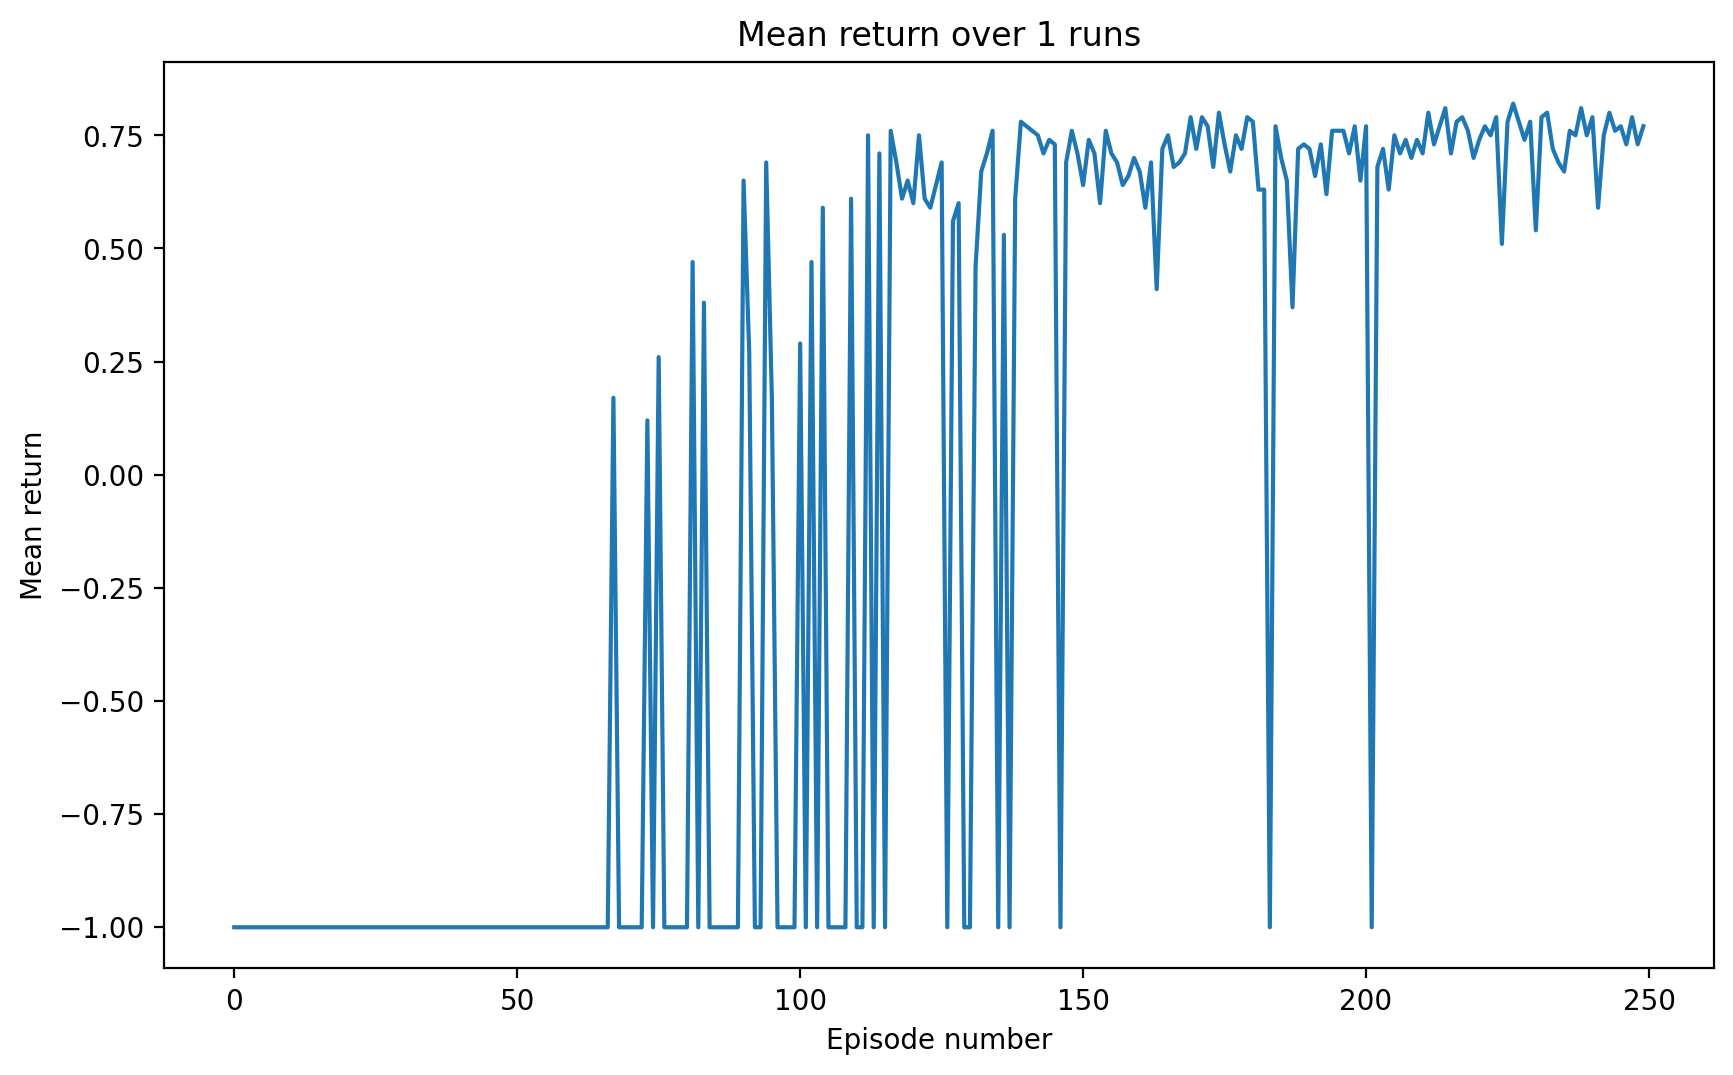

In [5]:
all_returns = np.stack(all_returns)
mean_returns = np.mean(all_returns, axis=0)
std_returns = np.std(all_returns, axis=0)
se_return = std_returns / np.sqrt(repeats)

# create figure
fig, ax = plt.subplots(figsize=(10, 6), dpi=100)
plt.plot(mean_returns)
plt.fill_between(
    range(episodes), mean_returns - se_return, mean_returns + se_return, alpha=0.2
)
plt.xlabel("Episode number")
plt.ylabel("Mean return")
plt.title(f"Mean return over {repeats} runs")
plt.show()

## Evaluating an agent's learned representations

In [6]:
eval_steps = 3000


value_matrix = np.zeros((env.grid_size, env.grid_size))
policy_matrix = np.zeros((env.grid_size, env.grid_size, env.action_space.n))
hidden_matrix = np.zeros((env.grid_size, env.grid_size, model_params["h_size"]))

obs = env.reset(objects={})
for i in range(eval_steps):
    action = env.action_space.sample()
    logits, value = agent.model.forward(obs)
    hidden = agent.model.encode(obs)
    value_matrix[env.agent_pos[0], env.agent_pos[1]] = value.detach().numpy()
    policy_matrix[env.agent_pos[0], env.agent_pos[1], :] = (
        torch.softmax(logits, dim=-1).detach().numpy()
    )
    hidden_matrix[env.agent_pos[0], env.agent_pos[1], :] = hidden.detach().numpy()
    obs, reward, done, info = env.step(action)
    if done:
        obs = env.reset()

### Examining the learned value function

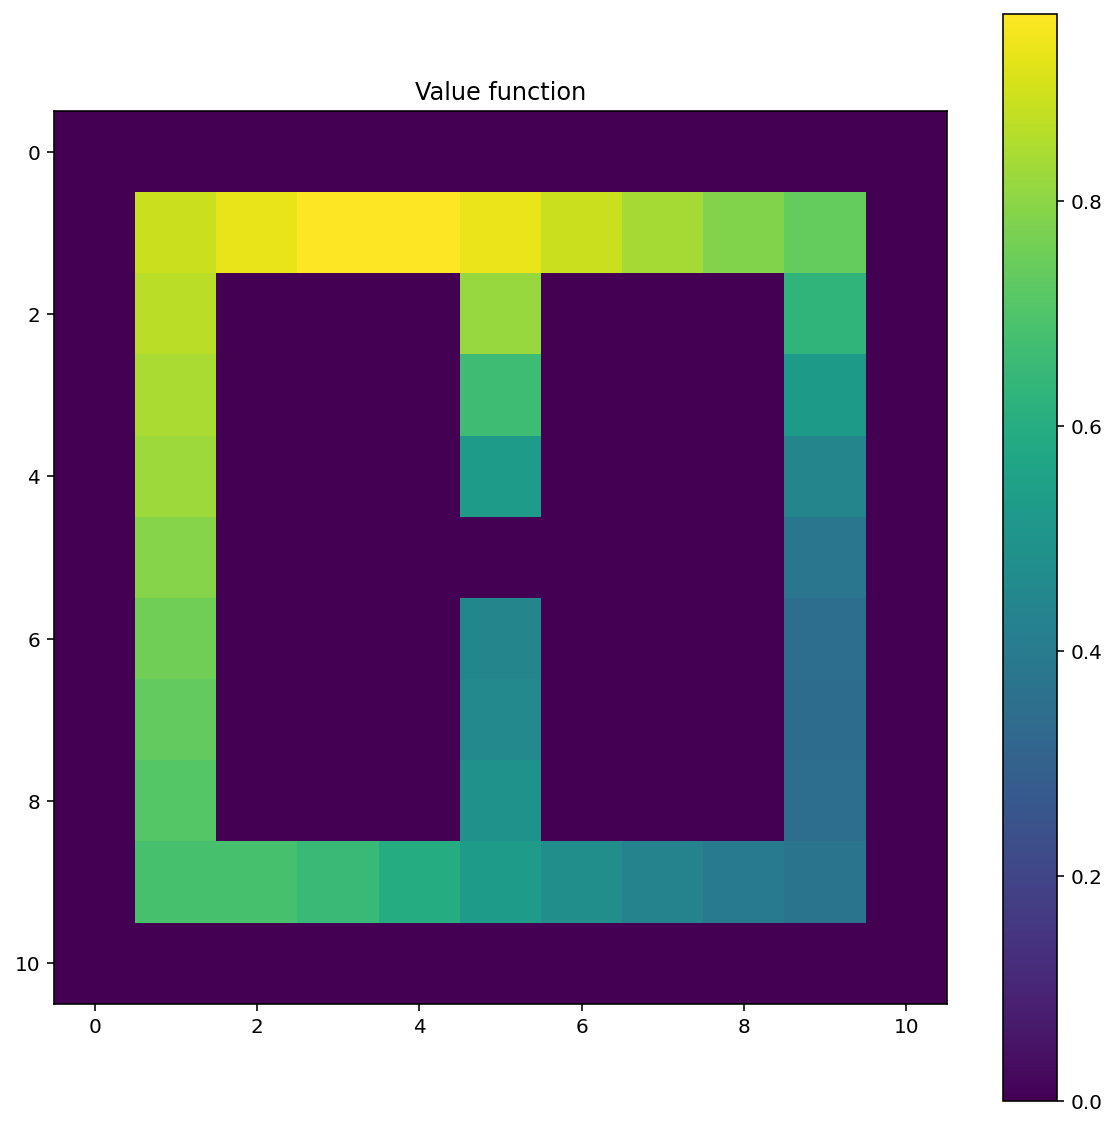

In [7]:
plt.figure(figsize=(10, 10))
plt.imshow(value_matrix)
plt.colorbar()
plt.title("Value function")
plt.show()

### Examining the PCA of the learned hidden state

In [8]:
# use pca to reduce dimensionality of hidden states to 2
from sklearn.decomposition import PCA

hidden_matrix_full = hidden_matrix.reshape(-1, model_params["h_size"])
# remove all cells where the agent has not been
hidden_matrix = hidden_matrix_full[np.sum(hidden_matrix_full, axis=1) != 0].copy()

pca = PCA(n_components=2)
pca.fit(hidden_matrix)
hidden_pca = pca.transform(hidden_matrix.reshape(-1, model_params["h_size"]))

# create matrix of ground-truth positions using arange
pos_matrix = np.zeros((env.grid_size, env.grid_size, 2))
pos_matrix[:, :, 0] = np.arange(env.grid_size)
pos_matrix[:, :, 1] = np.arange(env.grid_size)[:, np.newaxis]

# remove all cells where the agent has not been
pos_matrix = pos_matrix.reshape(-1, 2)[np.sum(hidden_matrix_full, axis=1) != 0].copy()

# Do a procrustrus alignment of the hidden states to the ground-truth positions
from scipy.spatial import procrustes

pos_matrix_trans, hidden_pca_trans, disparity = procrustes(pos_matrix, hidden_pca)

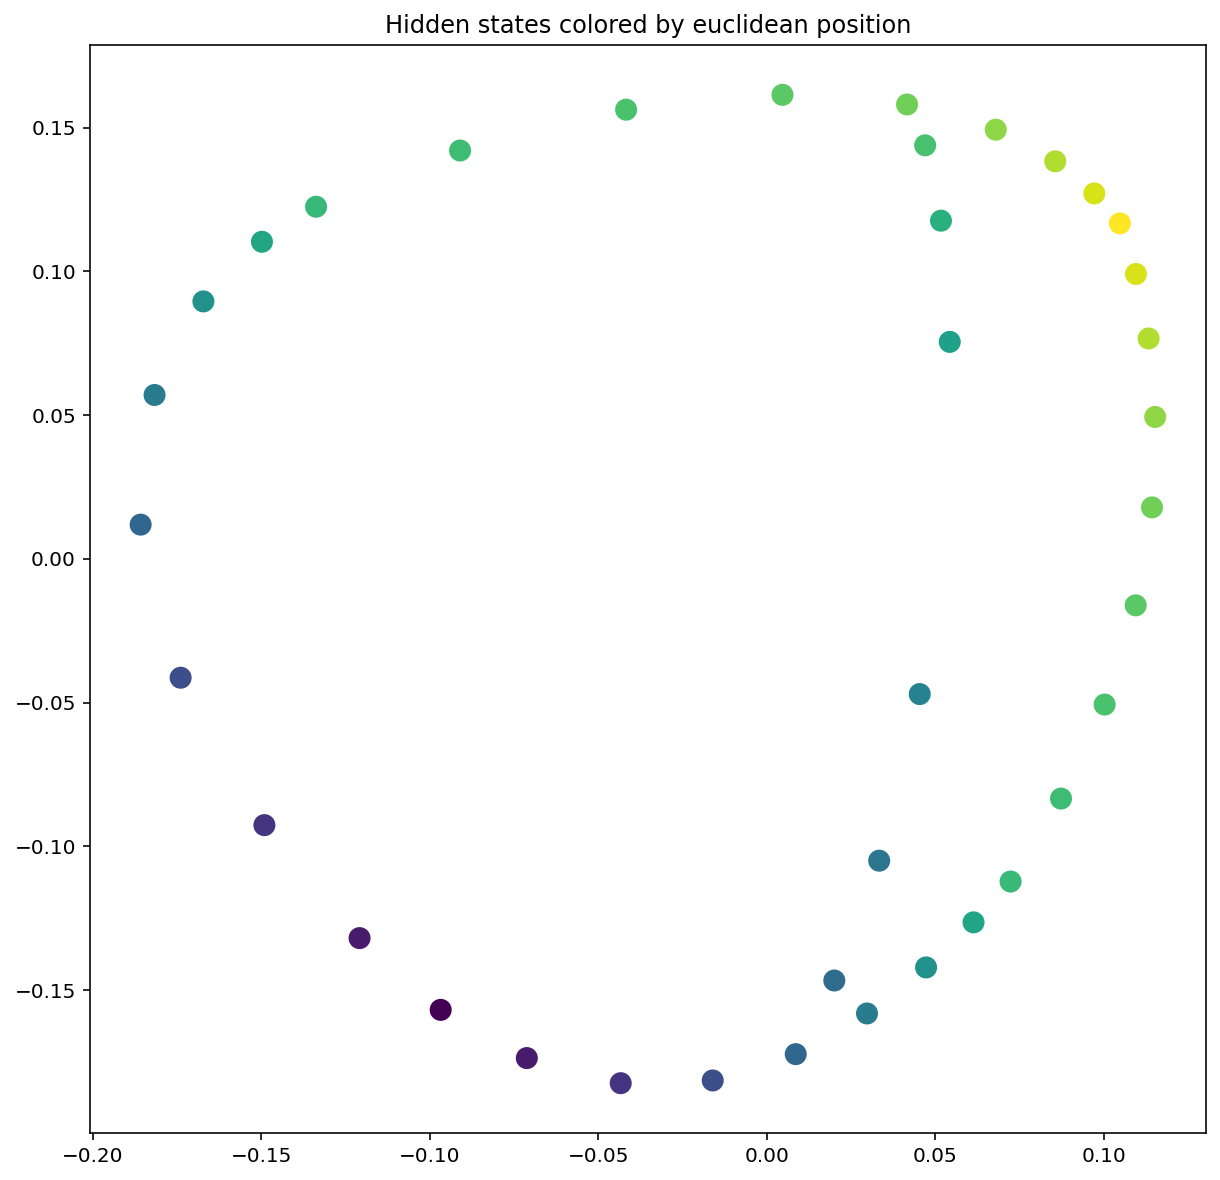

In [9]:
# plot hidden states as a scatter plot
# color the points by their euclidean position in the grid
# this should show that the hidden states cluster by position

colors = np.zeros((env.grid_size, env.grid_size))
for i in range(env.grid_size):
    for j in range(env.grid_size):
        colors[i, j] = np.linalg.norm(np.array([i, j]))

colors = colors.reshape(-1)
colors = colors[np.sum(hidden_matrix_full, axis=1) != 0]

plt.figure(figsize=(10, 10))
plt.scatter(hidden_pca_trans[:, 0], hidden_pca_trans[:, 1], c=colors, s=100)
plt.title("Hidden states colored by euclidean position")
plt.show()

### Training a classifier on the learned hidden state

In [10]:
# make onehot version of pos_matrix that is [num_states, grid_size * grid_size]

pos_matrix_onehot = np.zeros((pos_matrix.shape[0], env.grid_size * env.grid_size))
for i in range(pos_matrix.shape[0]):
    pos_matrix_onehot[i, int(pos_matrix[i, 0] * env.grid_size + pos_matrix[i, 1])] = 1

pos_matrix_onehot = np.argmax(pos_matrix_onehot, axis=-1)

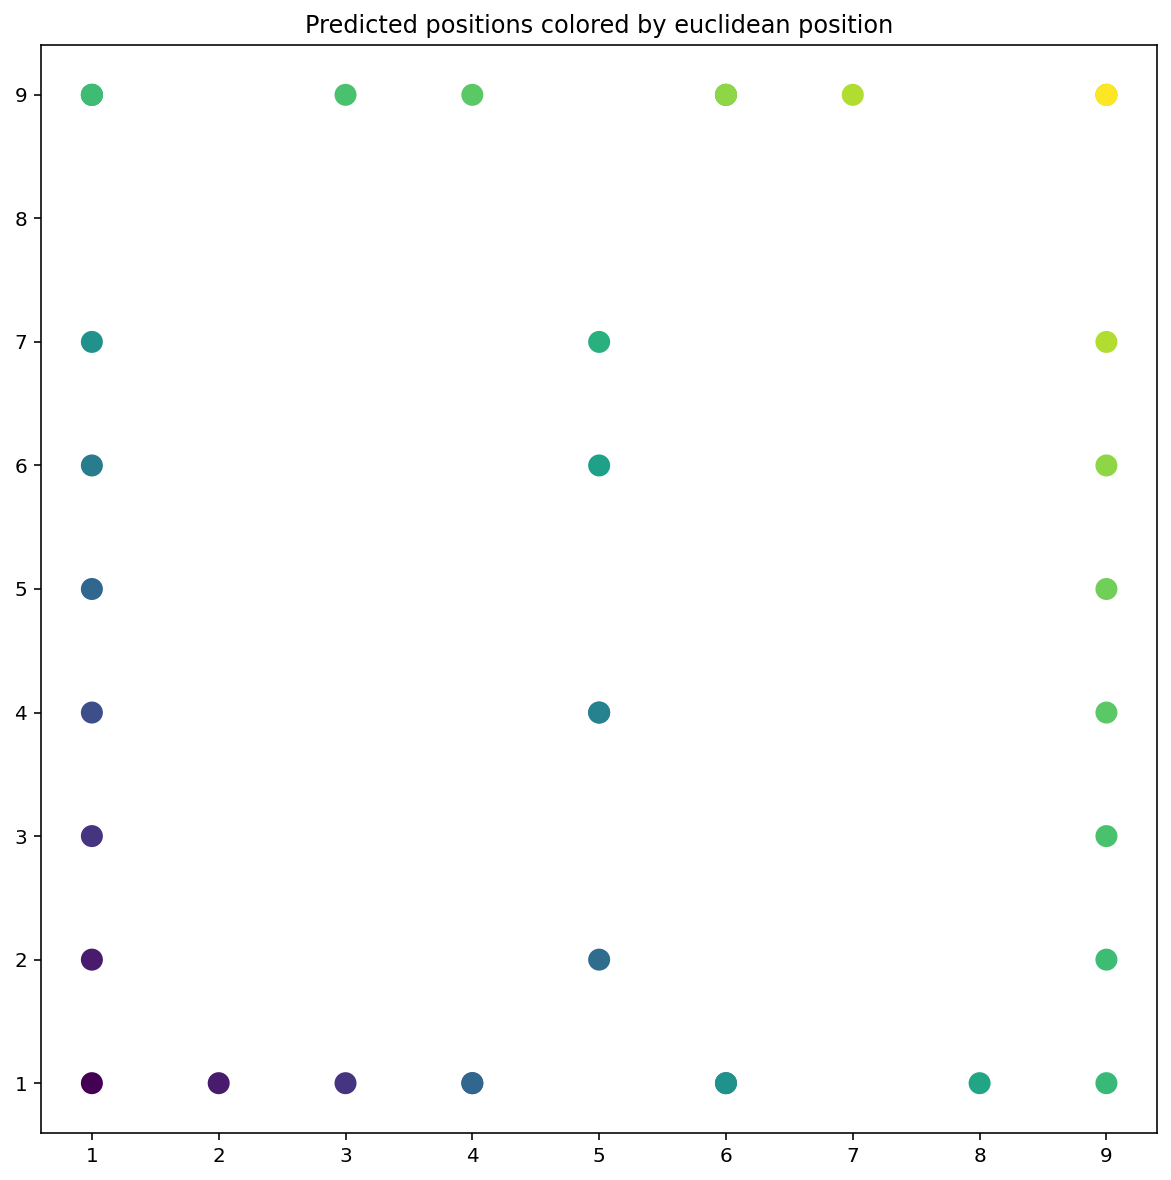

In [11]:
# train a classifier to predict the position from the hidden state
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    hidden_matrix, pos_matrix_onehot, test_size=0.2, random_state=42
)

reg = LogisticRegression(max_iter=500).fit(X_train, y_train)
score = reg.score(X_test, y_test)

# plot the predicted positions as a scatter plot
# the positions should be clustered by position

preds = reg.predict(hidden_matrix)
# convert preds to grid coordinates
preds = np.array([preds // env.grid_size, preds % env.grid_size]).T


plt.figure(figsize=(10, 10))
plt.scatter(preds[:, 0], preds[:, 1], c=colors, s=100)
plt.title("Predicted positions colored by euclidean position")
plt.show()